![header](../figures/DC_MapMed_OSE-banner.png)

***
**Authors:**  Datlas & IGE <br>
**Copyright:** 2022 Datlas & IGE <br>
**License:** MIT

<div class="alert alert-block alert-success">
    <h1><center>Perform baseline OI</center></h1>
    <h5><center>
    <h5><center>This notebook shows how to address the data challenge by performing a mapping technique baseline: an optimal interpolation.</h5> 
</div> 






The notebook is structured as follow: 

    1) Optimal interpolation principle
    2) Set up optimal interpolation parameters,
    3) Read observations,
    4) Run optimal interpolation 
    4) Save the outputs  

In [1]:
%matplotlib inline

import xarray as xr
import numpy
import warnings
import logging
import sys
import os
warnings.filterwarnings('ignore')
#sys.path.remove('/Users/sammymetref/Documents/DataChallenges/DC_IW_crossoverCal/2022a_mapping_HFdynamic')

logger = logging.getLogger()
logger.setLevel(logging.INFO)

sys.path.append('..')

from src.mod_oi import *
from src.mod_inout import *

<div class="alert alert-info" role="alert">

<h2> Optimal interpolation principle </h2>

</div>



Here, we assume a vector of observations, noted $y$ defined as:

$$y = H x + \epsilon $$

where $H$ is a linear observation operator between the reconstruction grid space and the observation space
, $x$ is the state to estimate and $\epsilon$ is an independent observation error.

The optimal interpolation consists in estimating an analysed state $x_{a}$ in combining the available observations to approximate the real state $x$:

$$x_{a} = K y $$
where $K$ is the weigth matrix defined as:

$$ K = BH^T(HBH^T + R)^{-1} $$

$B$ is the covariance matrix of $x$, and $R$ the covariance matrix of the error vector $\epsilon$ ($^T$ is the transpose operator)

<div class="alert alert-info" role="alert">

<h2> Set up optimal interpolation parameters </h2>

</div>

In [2]:
# OI Grid
lon_min = 1.                                           # domain min longitude
lon_max = 20.                                           # domain max longitude
lat_min = 30.                                            # domain min latitude
lat_max = 45.                                            # domain max latitude
time_min = numpy.datetime64('2021-01-01')                # domain min time
time_max = numpy.datetime64('2021-03-31')                # domain max time
dx = 0.1                                                 # zonal grid spatial step (in degree)
dy = 0.1                                                 # meridional grid spatial step (in degree)
dt = numpy.timedelta64(1, 'D')                           # temporal grid step

glon = numpy.arange(lon_min, lon_max + dx, dx)           # output OI longitude grid
glat = numpy.arange(lat_min, lat_max + dy, dy)           # output OI latitude grid
gtime = numpy.arange(time_min, time_max + dt, dt)        # output OI time grid

# OI parameters
Lx = 1.                                                  # Zonal decorrelation scale (in degree)
Ly = 1.                                                  # Meridional decorrelation scale (in degree)
Lt = 7.                                                  # Temporal decorrelation scale (in days)
noise = 0.05                                             # Noise level (5%)

<div class="alert alert-info" role="alert">

<h2> Read observations </h2>

</div>

In [3]:
# Get pseuso-observation
!wget https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/ocean-data-challenges/dc_MapMed_OSE/dc_obs.tar.gz
    

--2022-09-22 09:30:17--  https://ige-meom-opendap.univ-grenoble-alpes.fr/thredds/fileServer/meomopendap/extract/ocean-data-challenges/dc_MapMed_OSE/dc_obs.tar.gz
Résolution de ige-meom-opendap.univ-grenoble-alpes.fr (ige-meom-opendap.univ-grenoble-alpes.fr)… 129.88.191.39
Connexion à ige-meom-opendap.univ-grenoble-alpes.fr (ige-meom-opendap.univ-grenoble-alpes.fr)|129.88.191.39|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 200
Taille : 1637056 (1,6M) [application/octet-stream]
Sauvegarde en : « dc_obs.tar.gz »

dc_obs.tar.gz       100%[===================>]   1,56M  3,03MB/s    ds 0,5s    

2022-09-22 09:30:17 (3,03 MB/s) — « dc_obs.tar.gz » sauvegardé [1637056/1637056]



In [13]:
!tar -xvf dc_obs.tar.gz --directory ../inputs

x dc_obs/
x dc_obs/dt_med_alg_phy_l3_20210101-20210331_0-20_30-45.nc
x dc_obs/dt_med_j3_phy_l3_20210101-20210331_0-20_30-45.nc
x dc_obs/dt_med_h2b_phy_l3_20210101-20210331_0-20_30-45.nc
x dc_obs/dt_med_mdt_phy_l4_0.5-20.0_29-45.nc
x dc_obs/dt_med_s3b_phy_l3_20210101-20210331_0-20_30-45.nc
x dc_obs/dt_med_s3a_phy_l3_20210101-20210331_0-20_30-45.nc


In [14]:
!rm -f dc_obs.tar.gz

In [15]:
# Define outputs
output_directory = '../results/'
if not os.path.exists(output_directory):
    os.mkdir(output_directory)  
output_oi = f'{output_directory}/dc_MapMed_OSE_BASELINE_ssh.nc'

<div class="alert alert-info" role="alert">

<h2> Run optimal interpolation </h2>

</div>

In [16]:
%%time
# set OI param & grid
ds_oi1_param = oi_param(Lx, Ly, Lt, noise)
ds_oi1_grid = oi_grid(glon, glat, gtime)

# Read input obs + discard a bit...
coarsening = {'time': 5}
ds_oi1_obs = read_obs('../inputs/dc_obs/*l3*.nc',ds_oi1_grid,ds_oi1_param,coarsening)

# Run OI (take 1h on my laptop)
for it in range(len(gtime)):
    oi_core(it, ds_oi1_grid, ds_oi1_param, ds_oi1_obs)
    
ds_oi = ds_oi1_grid.drop(['gtime', 'ng', 'glon2', 'glat2', 'fglon', 'fglat', 'nobs'])
ds_oi = ds_oi.rename({'gssh': 'sla'})

INFO:root:     Set OI params...
INFO:root:     Set OI grid...
INFO:root:     Reading observations...


CPU times: user 1h 8min 34s, sys: 3min 3s, total: 1h 11min 38s
Wall time: 46min 27s



<div class="alert alert-info" role="alert">

<h2> Computing SSH from reconstructed SLA and CMEMS MDT fields</h2>

</div>

### Read CMEMS MDT fields (stored in /inputs/dc_obs) 

In [23]:
mdt = xr.open_dataset('../inputs/dc_obs/dt_med_mdt_phy_l4_0.5-20.0_29-45.nc')

# mdt = xr.open_dataset(mdt_file)
mdt_interp = mdt.interp(lon=ds_oi.lon, lat=ds_oi.lat)

ds_oi['ssh'] = ds_oi['sla'] + mdt_interp['mdt']

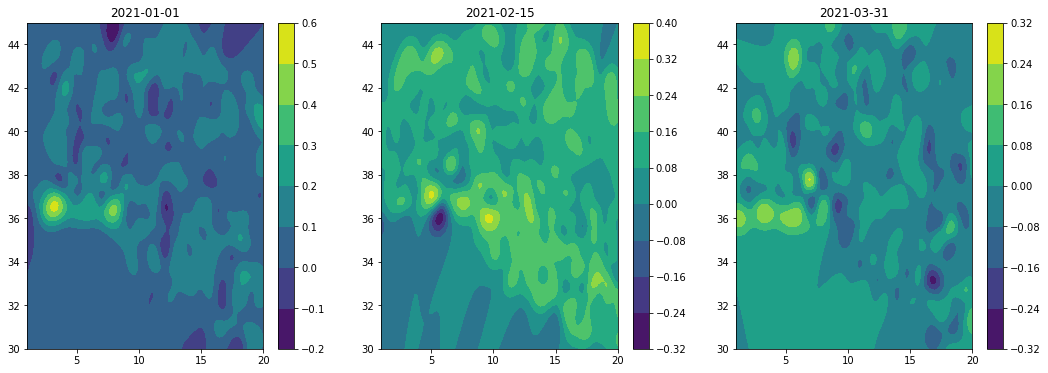

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))

ax1 = plt.subplot(131)
it = 0  
ax1.title.set_text(numpy.datetime_as_string(ds_oi.time[it].values, unit='D'))
plt.contourf(ds_oi.lon,ds_oi.lat,ds_oi.ssh[it,:,:])
plt.colorbar()

ax2 = plt.subplot(132)
it = 45
ax2.title.set_text(numpy.datetime_as_string(ds_oi.time[it].values, unit='D'))
plt.contourf(ds_oi.lon,ds_oi.lat,ds_oi.ssh[it,:,:]) 
plt.colorbar()

ax3 = plt.subplot(133)
it = 89
ax3.title.set_text(numpy.datetime_as_string(ds_oi.time[it].values, unit='D'))
plt.contourf(ds_oi.lon,ds_oi.lat,ds_oi.ssh[it,:,:])
plt.colorbar()
plt.show()


<div class="alert alert-info" role="alert">

<h2> Save the outputs </h2>

</div>

In [25]:
ds_oi.to_netcdf('../results/dt_med_mapping_baselineOI.nc')